# Linear regression coefficients


[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook we will understand the information provided by the coefficients of the linear regression model and calculate its variability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
# load the California House price data from Scikit-learn

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# scale the variables
X = MinMaxScaler().set_output(transform="pandas").fit_transform(X)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,0.539668,0.784314,0.043512,0.020469,0.008941,0.001499
1,0.538027,0.392157,0.038224,0.018929,0.067210,0.001141
2,0.466028,1.000000,0.052756,0.021940,0.013818,0.001698
3,0.354699,1.000000,0.035241,0.021929,0.015555,0.001493
4,0.230776,1.000000,0.038534,0.022166,0.015752,0.001198


## Coefficient variability

In [3]:
# Train 500 models on different partitions of X

s = dict()

for i in np.linspace(1, 500, num=500):
    
    # split data    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=int(i))
    
    # train model
    linreg = LinearRegression().fit(X_train, y_train)
    
    # store coefficients
    s[str(int(i))] = pd.Series(linreg.coef_)

In [4]:
# put coefficients in a dataframe

df = pd.concat(s, axis=1)
df.index = linreg.feature_names_in_
df = df.T

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
1,7.855325,0.860223,-29.212496,32.533937,0.684239,-5.462926
2,7.919423,0.808462,-32.066956,32.728056,0.624559,-6.574072
3,8.003544,0.872742,-32.748139,40.107737,0.754104,-5.520501
4,7.880499,0.803695,-32.515462,34.512223,0.555273,-6.631170
5,7.859912,0.821066,-30.771436,35.392139,0.840508,-6.659695


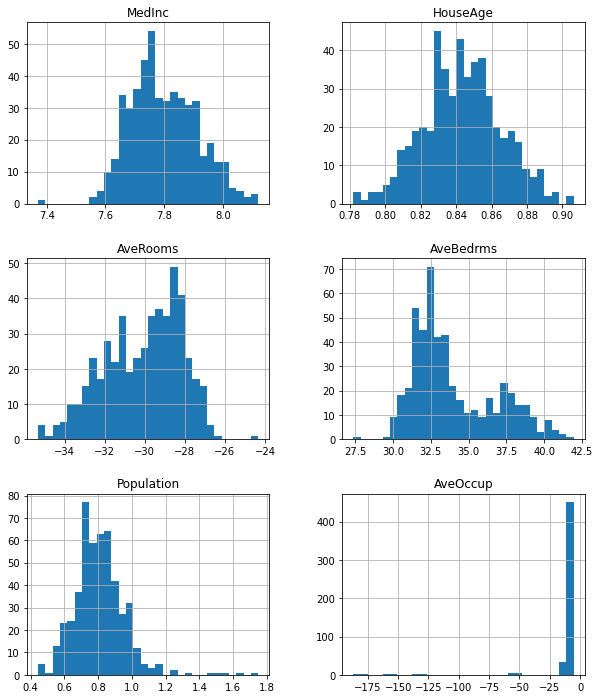

In [5]:
# Display variability of coefficients

df.hist(bins=30, figsize=(10, 12))
plt.show()

In [6]:
# Summarize variability of coefficients

coeff_summary = df.agg(["mean", "std"])
coeff_summary

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
mean,7.799373,0.843488,-30.088385,33.968347,0.811338,-9.323211
std,0.113091,0.022102,1.922136,2.729052,0.155688,17.720183


## Coefficient direction (sign)

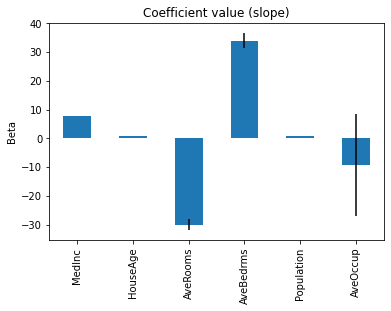

In [7]:
s = pd.Series(
    coeff_summary.loc["mean"],
    index=linreg.feature_names_in_,
)

s.plot.bar(yerr=coeff_summary.loc["std"])
plt.ylabel("Beta")
plt.title("Coefficient value (slope)")
plt.show()

We see that the variability of the coefficients is different. `AveOccup` is the most variable. Or in other words, it has the biggest estimation error.

We also see that the variables `AveRooms` and `AveBdrms` have opposite direction. We'd expect, intuitively that they have the same direction. And we also expect these variables to be highly correlated. More on this later.

## Coefficient absolute value - feature importance

This is what we normally use as a measure of feature importance.

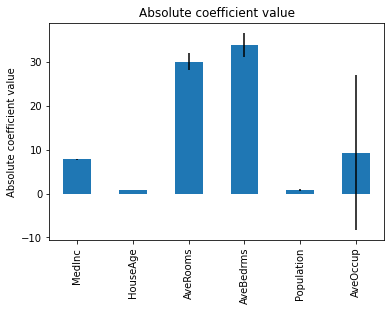

In [8]:
# Plot mean coefficient and std

s = pd.Series(
    np.abs(coeff_summary.loc["mean"]),
    index=linreg.feature_names_in_,
)

s.plot.bar(yerr=coeff_summary.loc["std"])
plt.ylabel("Absolute coefficient value")
plt.title("Absolute coefficient value")
plt.show()

From the previous plot, we'd expect the variables `AveRooms` and `AveBdrms` to be the ones with the highest importance. However, the coefficients for those variables also shows more variability, or a bigger error. Then, we can trust them less.

## t

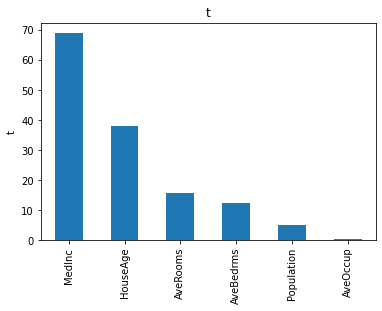

In [9]:
# estimate and plot t

s = pd.Series(
    np.abs(coeff_summary.loc["mean"])/coeff_summary.loc["std"],
    index=linreg.feature_names_in_,
)

s.plot.bar()
plt.ylabel("t")
plt.title("t")
plt.show()

After correcting the coefficient by its error, we see that `MedInc` is a more robust predictor of house price.

## Cross validation

We'd probably won't train 500 models to obtain the coefficient's error. But we could infer it using cross-validation.

In [10]:
# we use cross-validation to estimate
# coefficient's variability

results = cross_validate(
    estimator=linreg,
    X=X_train,
    y=y_train,
    scoring="r2",
    cv=5,
    return_train_score=True,
    return_estimator=True,
)

results

{'fit_time': array([0.0089972 , 0.00499773, 0.00349975, 0.0099988 , 0.00399756]),
 'score_time': array([0.00600815, 0.00161481, 0.002002  , 0.00299954, 0.0019989 ]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_score': array([0.52504554, 0.49338104, 0.54262472, 0.54395095, 0.52401754]),
 'train_score': array([0.53629996, 0.54195681, 0.53243437, 0.53217046, 0.53481389])}

In [11]:
# R2 in train set

print("R2 in train set: mean, std")
np.mean(results['train_score']), np.std(results['train_score'])

R2 in train set: mean, std


(0.5355350974726584, 0.0035574920750000654)

In [12]:
# R2 in test set

print("R2 in test set: mean, std")
np.mean(results['test_score']), np.std(results['test_score'])

R2 in test set: mean, std


(0.5258039582841565, 0.018260688279630583)

In [13]:
# Collect coefficients in dataframe

coeffs = pd.DataFrame()

for estimator in results["estimator"]:

    coeffs = pd.concat([coeffs, pd.Series(estimator.coef_)], axis=1)

coeffs.columns = [str(i) for i in range(1, 6)]
coeffs.index = estimator.feature_names_in_

coeffs

,1,2,3,4,5
MedInc,7.683438,7.910415,7.572398,7.677282,7.845622
HouseAge,0.828854,0.835736,0.837256,0.861382,0.886368
AveRooms,-28.254500,-33.587306,-27.075949,-28.662132,-30.435205
AveBedrms,31.532223,34.076150,30.290862,32.215434,37.114112
Population,0.804231,0.668001,0.981969,0.833060,0.766261
AveOccup,-12.300671,-5.678060,-6.241370,-6.583914,-5.977715


In [14]:
# Summarize coefficient's variability and
# calculate t

coeffs[["mean", "std"]] = coeffs.agg(["mean", "std"], axis=1)
coeffs["t"] = coeffs["mean"] / coeffs["std"]
coeffs

,1,2,3,4,5,mean,std,t
MedInc,7.683438,7.910415,7.572398,7.677282,7.845622,7.737831,0.137292,56.360202
HouseAge,0.828854,0.835736,0.837256,0.861382,0.886368,0.849919,0.023797,35.715751
AveRooms,-28.254500,-33.587306,-27.075949,-28.662132,-30.435205,-29.603018,2.532634,-11.688630
AveBedrms,31.532223,34.076150,30.290862,32.215434,37.114112,33.045756,2.654378,12.449529
Population,0.804231,0.668001,0.981969,0.833060,0.766261,0.810704,0.114250,7.095858
AveOccup,-12.300671,-5.678060,-6.241370,-6.583914,-5.977715,-7.356346,2.784037,-2.642331


### Coefficient direction (sign)

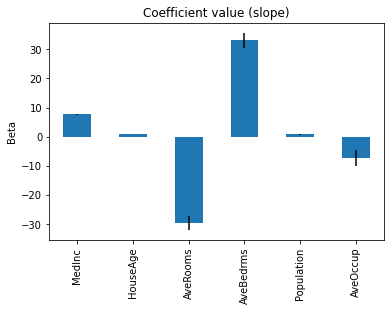

In [15]:
s = pd.Series(
    coeffs["mean"],
    index=linreg.feature_names_in_,
)

s.plot.bar(yerr=coeffs["std"])
plt.ylabel("Beta")
plt.title("Coefficient value (slope)")
plt.show()

We obtain similar results to those obtain by training 500 models. And we see that the errors are more conservative. 

### Coefficient absolute value

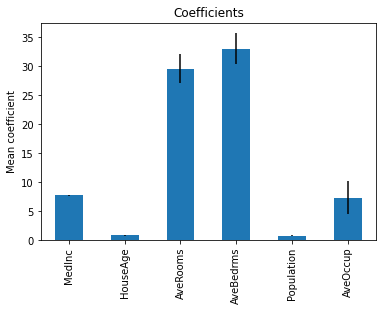

In [16]:
# plot mean coefficient plus std

coeffs["mean"].abs().plot.bar(yerr=coeffs["std"])
plt.ylabel("Mean coefficient")
plt.title("Coefficients")
plt.show()

### t

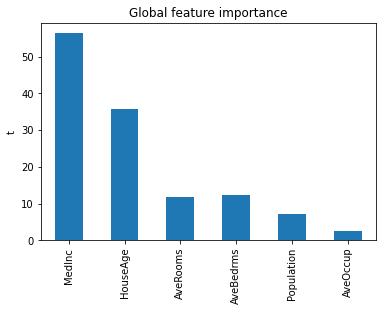

In [17]:
# plot t

coeffs["t"].abs().plot.bar()
plt.ylabel("t")
plt.title("Global feature importance")
plt.show()

With cross-validation we also see that `MedInc` is a more robust contributor to house price, but the difference to `AveRooms` and `AveBdrms` is smaller because the error of the coefficients was smaller. The error is smaller because we have less samples to estimate it from.

### p-values

With the value of t and the degrees of freedom, we can calculate the p-value for each coefficient utilizing `scipy.stats`.

In [18]:
coeffs["t"]

MedInc        56.360202
HouseAge      35.715751
AveRooms     -11.688630
AveBedrms     12.449529
Population     7.095858
AveOccup      -2.642331
Name: t, dtype: float64

In [19]:
# degrees of freedom

N = np.round(len(X_train) / 5, 0) # number of obs in each CV round
p = 6 # number of features

df = N - p - 1

df

2883.0

In [20]:
# 2 tail t-test (the coefficients can be 
# greater or smaller than 0)

# the p-values
stats.t.sf(np.abs(coeffs["t"]), df=df)*2

array([0.00000000e+000, 1.20159578e-231, 7.16222877e-031, 1.07906036e-034,
       1.61133070e-012, 8.27827525e-003])

All regression coefficients are significant.

Here a link about how to find the p-values with the t-statistic: https://www.statology.org/p-value-from-t-score-python/